# 1.0 Overview of the data

In [1]:
import math
import time
import re
import os
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from collections import Counter
import sklearn.metrics as metrics
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('drive/My Drive/Colab Notebooks')
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [ ]:
!ls

 data
 Data-Analysis.ipynb
 database
 Data_pre-processing.ipynb
 NLP-content-based-recomendation.ipynb
 pickles
 plots
'Recommendation Systems with CF and DL Techniques.ipynb'
'temp- test-code.ipynb'
 word2vec_model


In [3]:
data = pd.read_csv('data/amazon-clothing-info.csv', index_col=False)


In [4]:
print ('Number of data points : ', data.shape[0], 
       '\nNumber of features/variables:', data.shape[1])

Number of data points :  28395 
Number of features/variables: 19


### Tổng quát







In [6]:
# trong raw dataset có 19 columns feature.
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

Trong 19 features , chỉ lấy 7 features để nghiên cứu và tích hợp cho hệ thống shop online.


    1. asin  (chỉ số định danh tiêu chuẩn của amazon)
    2. brand ( nhãn hiệu của sản phẩm )
    3. color ( Màu của sản phẩm, trong đó một hàng có thể chứa nhiều màu   a value ex: red and black stripes ) 
    4. product_type_name (loại sản phẩm tương tự categories, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url của hình vừa )
    6. large_image_url (url của hình lớn)
    7. title (title of the product.)



In [7]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'large_image_url']]

In [8]:
print ('Number of data points : ', data.shape[0], 
       '\nNumber of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  28395 
Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,large_image_url
0,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,https://images-na.ssl-images-amazon.com/images...
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,https://images-na.ssl-images-amazon.com/images...
2,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,https://images-na.ssl-images-amazon.com/images...
3,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,https://images-na.ssl-images-amazon.com/images...
4,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,https://images-na.ssl-images-amazon.com/images...


# 2.1 Missing data for various features.

##  Basic stats for the feature: product_type_name

In [9]:
print(data['asin'].describe())

count          28395
unique         28395
top       B01MYOUTXH
freq               1
Name: asin, dtype: object


In [10]:

print(data['product_type_name'].describe())


count     28395
unique       57
top       SHIRT
freq      21513
Name: product_type_name, dtype: object


In [11]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'APPAREL' 'BOOKS_1973_AND_LATER' 'HAT' 'SPORTING_GOODS' 'SWEATER'
 'ACCESSORY' 'UNDERWEAR' 'HANDBAG' 'OUTERWEAR'
 'OUTDOOR_RECREATION_PRODUCT' 'DRESS' 'SLEEPWEAR' 'ADULT_COSTUME'
 'MISC_OTHER' 'HEALTH_PERSONAL_CARE' 'BLAZER' 'CONSUMER_ELECTRONICS'
 'SHOES' 'SHORTS' 'AUTO_PART' 'HOME' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR'
 'TOYS_AND_GAMES' 'PANTS' 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'SKIRT'
 'BEAUTY' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS'
 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'BRA' 'SHIRTS'
 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'VIDEO_DVD' 'GOLF_CLUB'
 'MUSIC_POPULAR_VINYL' 'GUILD_ACCESSORIES' 'SUIT'
 'POWERSPORTS_PROTECTIVE_GEAR' 'SAFETY_SUPPLY' 'BAG'
 'MECHANICAL_COMPONENTS' 'SOUND_AND_RECORDING_EQUIPMENT' 'BABY_PRODUCT'
 'JEWELRY' 'ABIS_APPAREL' 'OUTDOOR_LIVING' 'BUILDING_MATERIAL' 'LUGGAGE'
 'BABY_COSTUME' 'POWERSPORTS_VEHICLE_PART' 'PET_SUPPLIES']


In [12]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 21513),
 ('BOOKS_1973_AND_LATER', 3333),
 ('APPAREL', 1053),
 ('ACCESSORY', 559),
 ('SPORTING_GOODS', 391),
 ('OUTERWEAR', 340),
 ('DRESS', 177),
 ('SWEATER', 155),
 ('BLAZER', 127),
 ('OUTDOOR_RECREATION_PRODUCT', 106)]

##  Basic stats for the feature: brand

In [13]:
print(data['brand'].describe())


count         28302
unique         3640
top       TOOGOO(R)
freq            177
Name: brand, dtype: object


In [14]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('TOOGOO(R)', 177),
 ('SODIAL(R)', 133),
 ('Reiss', 125),
 ('Ash City', 124),
 ('G by GUESS', 121),
 ('Black Temptation', 121),
 ('Anna-Kaci', 117),
 ('Absolutely', 115),
 ('Nanon', 115),
 ('Worthington', 106)]

##  Basic stats for the feature: color

In [15]:

print(data['color'].describe())


count     28385
unique     4527
top       Black
freq       5181
Name: color, dtype: object


In [16]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[('Black', 5181),
 ('White', 3220),
 ('Blue', 1351),
 ('Red', 1095),
 ('Pink', 810),
 ('Purple', 531),
 ('Grey', 478),
 ('Green', 469),
 ('Gray', 463),
 ('Navy', 369)]

## Basic stats for the feature: title


In [17]:
print(data['title'].describe())

# All of the products have a title. 


count                                                 28395
unique                                                26069
top       FINEJO Casual Women Long Sleeve Lace Irregular...
freq                                                     47
Name: title, dtype: object


In [18]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [19]:



'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

# 2.2 Remove near duplicate items

## 2.2.1 Understand about duplicates.

In [20]:

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


These shirts are exactly same except in size (S, M,L,XL)

<table>
<tr> 
<td><img src="https://images-na.ssl-images-amazon.com/images/I/61Gdr%2BeLLBL._AC_UX385_.jpg" width=100 height=100> :B00AQ4GMCK</td>
<td><img src="https://images-na.ssl-images-amazon.com/images/I/61Gdr%2BeLLBL._AC_UX385_.jpg"width=100 height=100> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="https://images-na.ssl-images-amazon.com/images/I/61Gdr%2BeLLBL._AC_UL1000_.jpg",width=100 height=100> :B00AQ4GMLQ</td>
<td><img src="https://images-na.ssl-images-amazon.com/images/I/61Gdr%2BeLLBL._AC_UL1000_.jpg",width=100 height=100> :B00AQ4GN3I</td>
</tr>
</table>

 These shirts exactly same except  in color

<table>
<tr> 
<td><img src="https://images-na.ssl-images-amazon.com/images/I/71PsKaQKsyL._AC_SX569_.jpg" width=100 height=100> :B00G278GZ6</td>


<td><img src="https://images-na.ssl-images-amazon.com/images/I/71NIA5tTZ5L._AC_SL1250_.jpg" width=100 height=100> :B00G278Z2A</td>

</tr>
</table>

 In our data there are many duplicate products like the above examples, we need to de-dupe them for better results.


## 2.2.2 Remove duplicates : Part 1

In [21]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,large_image_url
0,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,https://images-na.ssl-images-amazon.com/images...
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,https://images-na.ssl-images-amazon.com/images...
2,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,https://images-na.ssl-images-amazon.com/images...
3,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,https://images-na.ssl-images-amazon.com/images...
4,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,https://images-na.ssl-images-amazon.com/images...


In [22]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [23]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,large_image_url
11232,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,https://images-na.ssl-images-amazon.com/images...
21223,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,https://images-na.ssl-images-amazon.com/images...
14232,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,https://images-na.ssl-images-amazon.com/images...
13436,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,https://images-na.ssl-images-amazon.com/images...
23713,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,https://images-na.ssl-images-amazon.com/images...


 Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [24]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [25]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [26]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

We removed  the dupliactes which differ only at the end.

In [27]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


## 2.2.3 Remove duplicates : Part 2

<pre>

Trong ô trước đó, đã sắp xếp toàn bộ dữ liệu theo thứ tự bảng chữ cái của tiêu đề, sau đó loại bỏ các tiêu đề liền kề và tiêu đề rất giống nhau.
 Nhưng có một số sản phẩm có tiêu đề không liền kề nhưng rất giống nhau.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [28]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop() 
    # i took last element of indices
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [29]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [30]:
print('Number of data points after stage two of dedupe: ',data.shape[0])


Number of data points after stage two of dedupe:  16435


In [31]:
data = data[data.groupby('product_type_name')['product_type_name'].transform('count').ge(20)]

In [32]:
print(data['product_type_name'].describe())

count     16319
unique       18
top       SHIRT
freq      13134
Name: product_type_name, dtype: object


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

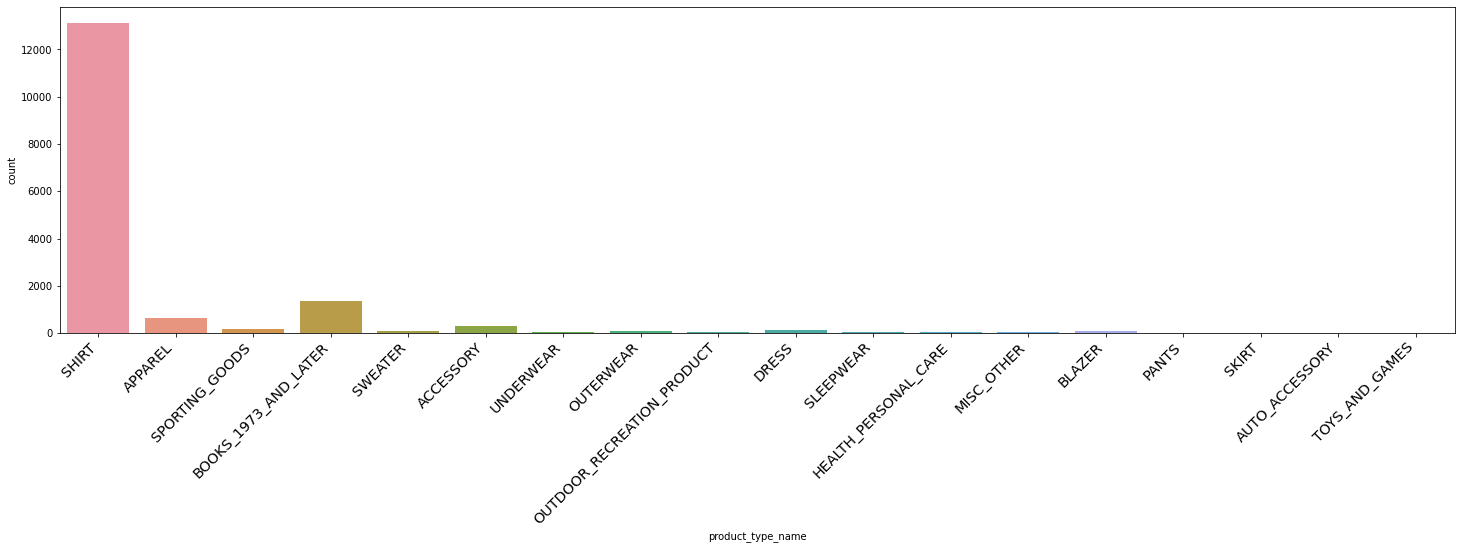

In [42]:
plt.figure(figsize=(25,6))
sns.countplot(data['product_type_name'])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [34]:
data.to_pickle('pickles/clothing_info')

# 3.0 Text pre-processing

In [35]:
data = pd.read_pickle('pickles/clothing_info')

# NLTK download stop words. [RUN ONLY ONCE]
import nltk
nltk.download('stopwords')
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
# use the list of stop words that are downloaded from nltk lib.

stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'was', 'so', 'doing', 'against', 'his', 'into', 'myself', 'because', 'there', 'those', 'between', 'will', 'above', 'further', "should've", 'ours', 'but', 've', 'does', 'after', 'below', 'me', 'as', 'whom', 'very', 'weren', "shan't", 'theirs', 'again', 'that', 'nor', 's', 'll', 'were', 'if', "you've", "won't", "that'll", 'y', 'up', 'themselves', 'it', 'is', 'by', "don't", 'hers', "haven't", "mightn't", 'shan', 'm', 'these', 'this', 'which', 'with', "wouldn't", 'how', 'the', 'more', 'ma', 're', 'yourself', "mustn't", 'some', 't', 'be', 'do', 'only', 'had', 'no', 'hadn', 'my', "needn't", 'its', 'both', 'who', 'shouldn', 'did', 'during', 'i', 'are', 'our', "hadn't", 'hasn', 'to', 'other', 'wouldn', 'your', 'until', 'her', 'having', "she's", 'same', 'down', "you'd", 'ourselves', 'haven', 'has', 'than', 'mightn', 'any', 'she', 'their', 'them', "isn't", 'why', 'mustn', 'now', 'off', 'should', 'on', 'in', 'here', 'over', 'he', 'itself', "wasn't", "it's", 'a', 'and', 'once'

In [37]:
start_time = time.clock()
# take each title and text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

5.218539999999848 seconds


In [38]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,large_image_url
0,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,https://images-na.ssl-images-amazon.com/images...
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,https://images-na.ssl-images-amazon.com/images...
3,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,https://images-na.ssl-images-amazon.com/images...
5,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,https://images-na.ssl-images-amazon.com/images...
7,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,https://images-na.ssl-images-amazon.com/images...


In [39]:
data.to_pickle('pickles/clothing_info_preprocessed')

## Stemming 

In [40]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


argu
fish
